# RL4CRN tutorial notebook: Dose Response (CVODE)

Refer to the Logic Circuits tutorial for more information about the overall pipeline.


In [1]:
import os, sys, numpy as np

print("Python:", sys.version.split()[0])
print("CWD:", os.getcwd())


Python: 3.10.12
CWD: /local0/rossin/git/CRN-GenerativeAI/apps


## 1) Import RL4CRN helpers


In [2]:
from RL4CRN.utils.input_interface import (
    Configurator,
    make_task,
    make_session_and_trainer,
    print_task_summary,
)
from RL4CRN.utils.default_tasks.DoseResponseTaskKind import DoseResponseTaskKind


## 2) Build a template IO/CRN

Here we use the convenience builder `build_simple_IOCRN`, which provides an easy way to construct a I/O CRNs specifying dictionaries for input and output nodes.


In [3]:
from RL4CRN.utils.crn_builders import build_simple_IOCRN

# choose preset
cfg = Configurator.preset("paper")

# select simulator and set tolerances
cfg.solver.algorithm = "CVODE"
cfg.solver.rtol = 1e-10
cfg.solver.atol = 1e-10

# build template IO/CRN
species_labels = ['X_1', 'X_2', 'X_3']
crn, species_labels = build_simple_IOCRN(
    species=species_labels,
    production_input_map={"X_1": "u_1"},
    degradation_input_map={},
    dilution_map={},
    output_species="X_3",
    solver=cfg.solver,
)

print("Template CRN built.")
print(" - num_inputs:", crn.num_inputs)
print(" - num_species:", len(species_labels))
print(" - species:", species_labels)


Template CRN built.
 - num_inputs: 1
 - num_species: 3
 - species: ['X_1', 'X_2', 'X_3']


## 3) Build the reaction library (MAK)


In [4]:
from RL4CRN.utils.library_builders import build_MAK_library

# library components
library_components = build_MAK_library(crn, species_labels, order=2)

library, M, K, masks = library_components
print("Library built.")
print(" - M (num reactions in library):", M)
print(" - K (num parameters in library):", K)


Library built.
 - M (num reactions in library): 91
 - K (num parameters in library): 91


## 4) Define the task: RPA

- `kind="oscillator_mean"` selects the reward handler.
- `ic=("constant", 0.01)` sets initial concentrations.
- we use `u_values` to identify the combinations between input and disturbance
- we use `targets` to highlight the target output we seek to reach


In [5]:
from RL4CRN.utils.input_interface import get_task_kind
get_task_kind("dose_response").pretty_help()

### TaskKind `dose_response`

**Required params**
- `target`: float OR callable with named args (recommended)
- `dose_range`: Tuple[u_min, u_max, n]

**Optional params**
- `t_f`: float
- `n_t`: int
- `ic`: IC spec
- `weights`: weights spec
- `u_list`: explicit u_list
- `u_spec`: ('custom'|'grid'|'linspace', ...) escape hatch
- `norm`: int (default 1)
- `LARGE_NUMBER`: float (default 1e4)

**Notes**
- Default u_list is 1D linspace over dose_range with vectors shape (1,). If target is callable, its
  arg names are resolved via input_idx_dict/species_idx_dict.


In [6]:
task = make_task(
    template_crn=crn,
    library_components=library_components,
    kind="dose_response",
    species_labels=species_labels,
    params={
        "t_f": 100,
        "n_t": 1000,
        "ic": ("constant", 0.01),
        "weights": "transient",
        "u_spec": ("linspace", 0.0, 1.0, 10),
        "target" : lambda u_1: 2*u_1,  # A simple linear dose response
    }
)

print_task_summary(task)

# --- Optional safety checks (recommended) ---
print("Sanity checks:")
print(" - template num_inputs:", crn.num_inputs)
print(" - first u shape:", np.asarray(task.u_list[0]).shape)
print(" - first u length:", len(task.u_list[0]))
assert len(task.u_list[0]) == crn.num_inputs, "Input dimension mismatch: u has wrong length!"


Task: dose_response
time_horizon: (1000,) [0..100.0]
num scenarios: 10
first 3 u: [array([0.], dtype=float32), array([0.11111111], dtype=float32), array([0.22222222], dtype=float32)]

Sanity checks:
 - template num_inputs: 1
 - first u shape: (1,)
 - first u length: 1


## 5) Training configuration

We tune:
- `max_added_reactions`: episode length (how many reactions the agent can add)
- `epochs`: training iterations
- `render_every`: print progress cadence
- `seed`: reproducibility


In [7]:
# ---- Train config ----
cfg.train.max_added_reactions = 5
cfg.train.epochs = 5
cfg.train.render_every = 5
cfg.train.seed = 0

In [ ]:
# ---- rendering ----
cfg.render.n_best = 100
cfg.render.disregarded_percentage = 0.9
cfg.render.mode = {  # Mode of the experiment
    'style': 'logger', 
    'task': 'transients + dose-response', 
    'format': 'image',
    'topology': True
}

## 6) Inspect full configuration (optional)

`cfg.describe()` prints a nested configuration dictionary.


In [9]:
cfg.describe()

{'task': None,
 'solver': {'algorithm': 'CVODE', 'rtol': 1e-10, 'atol': 1e-10},
 'train': {'epochs': 5,
           'max_added_reactions': 5,
           'render_every': 5,
           'hall_of_fame_size': 50,
           'batch_multiplier': 10,
           'seed': 0,
           'n_cpus': None,
           'batch_size': None},
 'policy': {'width': 1024,
            'depth': 5,
            'deep_layer_size': 10240,
            'continuous_distribution': {'type': 'lognormal_1D'},
            'entropy_weights_per_head': {'structure': 2.0, 'continuous': 1.0, 'discrete': 0.0, 'input_influence': 0.0},
            'ordering_enabled': False,
            'constraint_strength': inf},
 'agent': {'learning_rate': 0.0001,
           'entropy_scheduler': {'entropy_weight': 0.001,
                                 'topk_entropy_weight': 1.0,
                                 'remainder_entropy_weight': 1.0,
                                 'entropy_update_coefficient': 1,
                                 'en

## 7) Create session + trainer

This step wires together:
- parallel environments
- observer/tensorizer/actuator/stepper interfaces
- policy + agent
- the chosen task reward function

The returned object:
- `trainer`: runs rollout → reward eval → policy update loops


In [10]:
import os
from datetime import datetime
from pytorch_lightning.loggers import CometLogger

task_name = "DoseResponse_Task"
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Expect these in your environment:
#   COMET_API_KEY   (required)
#   COMET_WORKSPACE (required)
api_key = os.environ["COMET_API_KEY"]
workspace = os.environ["COMET_WORKSPACE"]

logger = CometLogger(
    api_key=api_key,
    project=task_name,
    workspace=workspace,
    name=f"{task_name}_{timestamp}",
)

logger = logger.experiment


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/redsnic/doseresponse-task/0c5b7bc241a249e9834716b8e5fd1982



In [11]:
trainer = make_session_and_trainer(cfg, task, logger=logger)

## 8) Train and save checkpoints

We run for `cfg.train.epochs` epochs and periodically save a checkpoint.



[cvHandleFailure, Error: -15] At t = 11.6112264665219, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 16.158082290033, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 9.12573716886491, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 8.61137961209022, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 14.7843605244371, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 24.0579842132015, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 16.6068016049849, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 10.3360394636254, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 39.6945398047841, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 10.4430179389323, unable to satisfy inequality constraints.


[cvHandleF

/local0/rossin/git/CRN-GenerativeAI/.venv/lib/python3.10/site-packages/RL4CRN/environments/environment.py:506: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.95])
/local0/rossin/git/CRN-GenerativeAI/.venv/lib/python3.10/site-packages/RL4CRN/environments/environment.py:506: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.95])
/local0/rossin/git/CRN-GenerativeAI/.venv/lib/python3.10/site-packages/RL4CRN/environments/environment.py:506: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.95])
/local0/rossin/git/CRN-GenerativeAI/.venv/lib/python3.10/site-packages/RL4CRN/environments/environment.py:506: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.95])
/local0/rossin/git/CRN-GenerativeAI/.venv/lib/python3.10/site-packages/RL4CRN/environments/environment.py:506: UserWarning: The figure layout has changed to tight
  fig.tight_layout(re

Saved checkpoint: RPA_task_chkpt.pkl

[CVode, Error: -1] At t = 80.659403661633, mxstep steps taken before reaching tout.


[CVode, Error: -1] At t = 15.2914199925729, mxstep steps taken before reaching tout.


[CVode, Error: -1] At t = 13.9939258356028, mxstep steps taken before reaching tout.


[cvHandleFailure, Error: -15] At t = 16.911329697395, unable to satisfy inequality constraints.


[CVode, Error: -1] At t = 12.6025981140487, mxstep steps taken before reaching tout.


[CVode, Error: -1] At t = 12.1105971245824, mxstep steps taken before reaching tout.


[CVode, Error: -1] At t = 11.4957028472601, mxstep steps taken before reaching tout.


[cvHandleFailure, Error: -15] At t = 19.2293958286921, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 17.3365724203658, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 19.2977147035203, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 3.0031019

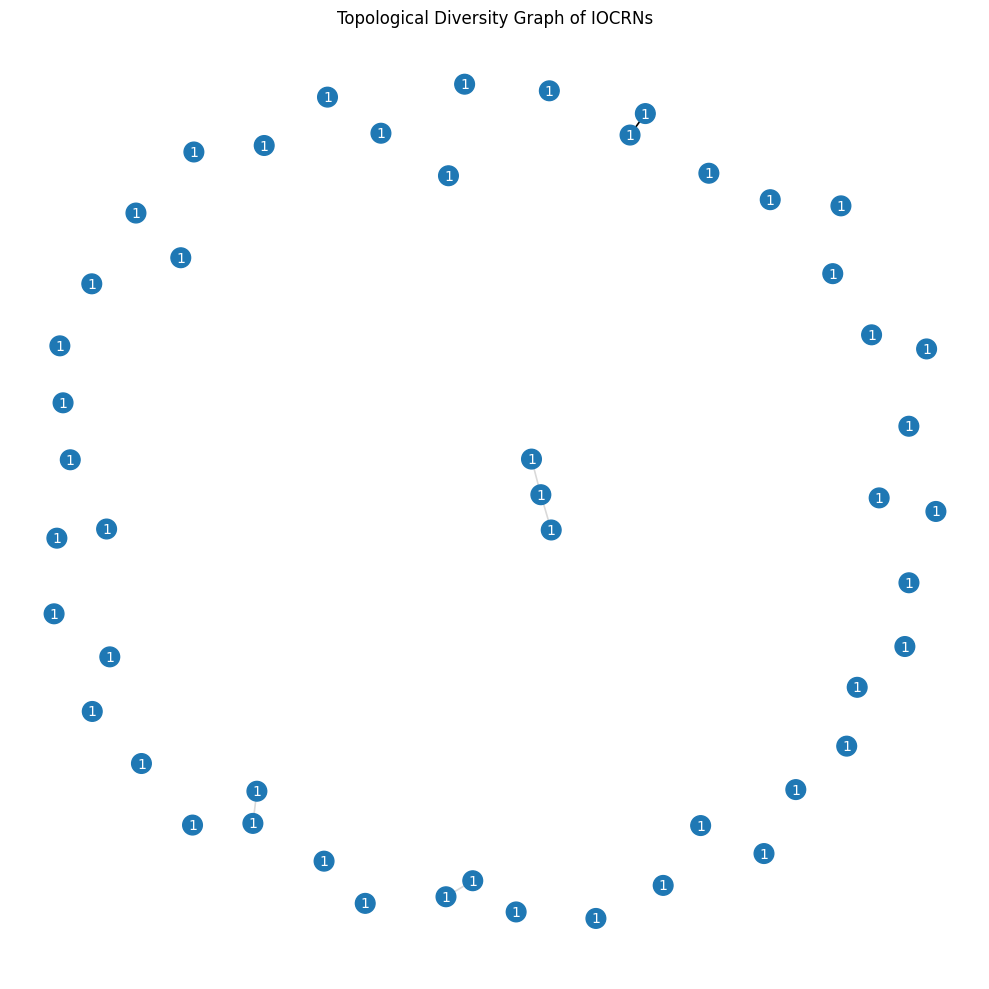

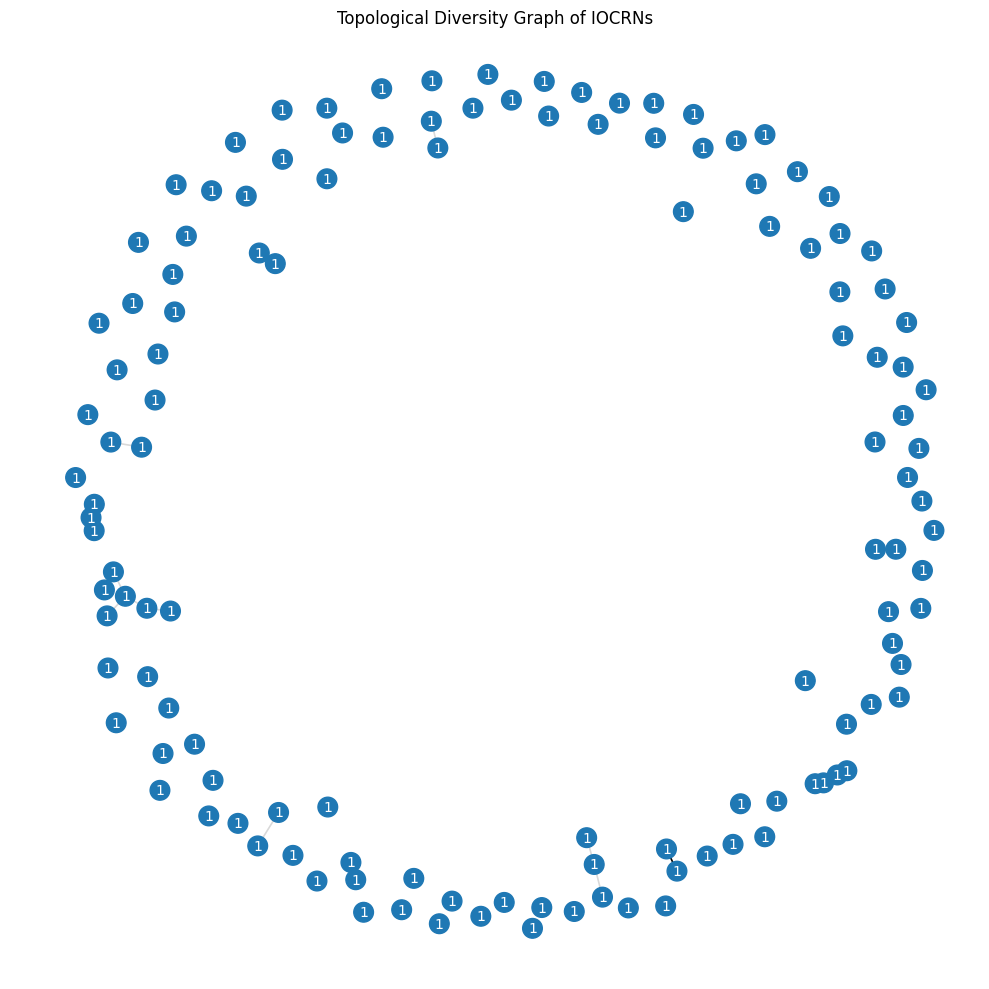

In [12]:
checkpoint_path = "RPA_task_chkpt.pkl"
trainer.run(epochs=cfg.train.epochs, checkpoint_path=checkpoint_path)


## 9) Inspect the best CRN

The trainer keeps a **Hall of Fame** of good CRNs found during rollouts.


In [13]:
trainer.inspect_best(plot=True)

best = trainer.best_crn()
print("Hall of Fame size:", len(trainer.s.mult_env.hall_of_fame))
if best is not None:
    print("Best loss:", best.last_task_info.get("reward", None))


Best CRN loss: 0.03144916106469542
Inputs: ['u_1'] 
Species: ['X_1', 'X_2', 'X_3'] 
Output Species: ['X_3'] 
∅ ----> X_1;  [MAK(1.0, u_1)]
X_1 ----> X_3;  [MAK(0.7473974227905273)]
X_2 ----> ∅;  [MAK(0.39382869005203247)]
X_3 ----> X_2 + X_2;  [MAK(0.4952118992805481)]
X_2 + X_2 ----> X_2;  [MAK(0.42405515909194946)]
X_3 + X_3 ----> X_1 + X_1;  [MAK(0.6065087914466858)]
Hall of Fame size: 50
Best loss: 0.03144916106469542


## 10) Sample and re-simulate

After training, we can **draw new CRN designs from the learned policy** (sampling runs in evaluation mode, i.e., no gradient updates) and **re-evaluate** them.

This is useful for:
- **Model exploration:** quickly inspect diverse candidates generated by the policy.
- **Controlled re-simulation:** re-run sampled CRNs under modified conditions (`u_list/u_spec`, `ic`, etc.).

Sampling produces a dedicated **sample Hall-of-Fame** that stores the best `K` sampled environments (lowest loss) for later inspection and checkpointing.


In [14]:
trainer.sample(10, 10, ic=("constant", 1.0))

We can now inspect newly sampled I/O CRNs.

Inputs: ['u_1'] 
Species: ['X_1', 'X_2', 'X_3'] 
Output Species: ['X_3'] 
∅ ----> X_1;  [MAK(1.0, u_1)]
∅ ----> X_3;  [MAK(0.7459886074066162)]
X_1 ----> ∅;  [MAK(0.8470849394798279)]
X_3 ----> X_2 + X_2;  [MAK(0.47273439168930054)]
X_2 + X_2 ----> X_3;  [MAK(0.24941851198673248)]
X_2 + X_3 ----> X_2 + X_2;  [MAK(0.9241653084754944)]
reward: 0.6091393339018208


/local0/rossin/git/CRN-GenerativeAI/.venv/lib/python3.10/site-packages/RL4CRN/utils/plotting_style.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(**cfg.get("legend_kwargs", {}))


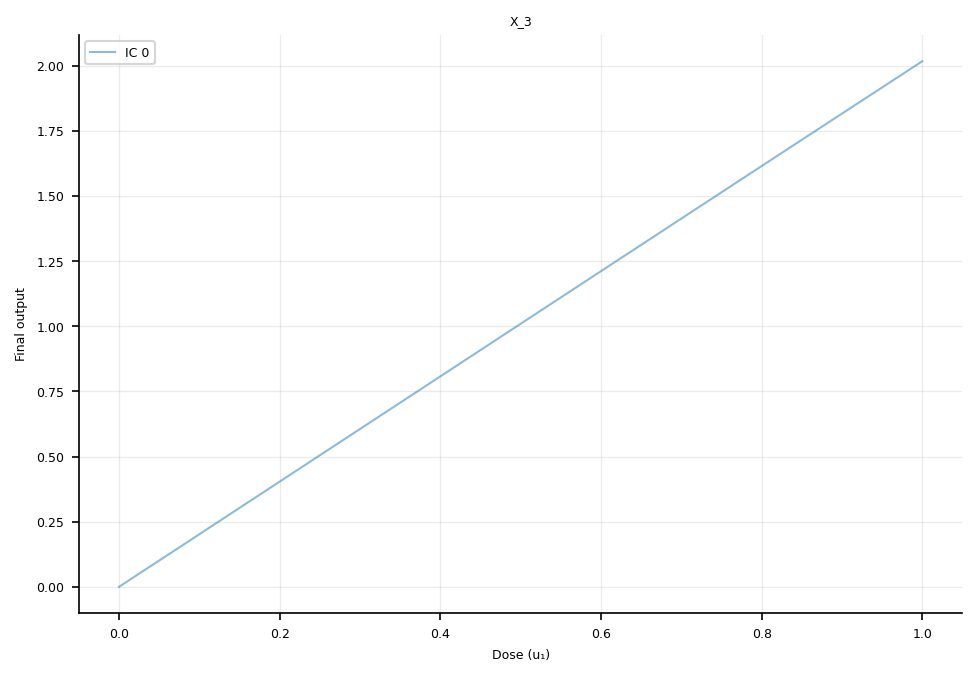

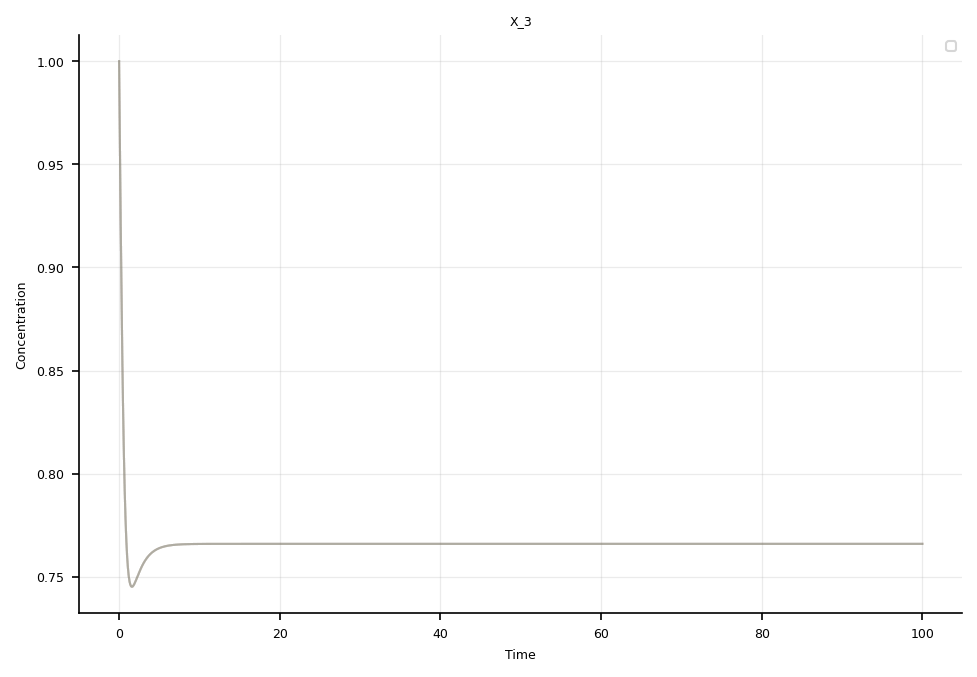

In [15]:
import matplotlib.pyplot as plt

index = 0
crn_s = trainer.get_sampled_crns()[index]
print(crn_s)
print("reward:", crn_s.last_task_info.get("reward", None))

# Plotters depend on your IOCRN implementation
crn_s.plot_transient_response(); plt.show()


Save again our results.

In [16]:
trainer.save(checkpoint_path)

Saved checkpoint: RPA_task_chkpt.pkl


## 11) Loading a saved Session/Trainer from a checkpoint

`load_session_and_trainer` reconstructs wiring and restores weights, history, HoFs, and RNG states.


In [17]:
from RL4CRN.utils.input_interface import load_session_and_trainer

trainer_loaded = load_session_and_trainer(checkpoint_path, device="cuda")
trainer_loaded.inspect_best()

Best CRN loss: 0.03144916106469542
Inputs: ['u_1'] 
Species: ['X_1', 'X_2', 'X_3'] 
Output Species: ['X_3'] 
∅ ----> X_1;  [MAK(1.0, u_1)]
X_1 ----> X_3;  [MAK(0.7473974227905273)]
X_2 ----> ∅;  [MAK(0.39382869005203247)]
X_3 ----> X_2 + X_2;  [MAK(0.4952118992805481)]
X_2 + X_2 ----> X_2;  [MAK(0.42405515909194946)]
X_3 + X_3 ----> X_1 + X_1;  [MAK(0.6065087914466858)]


## 12) Re-simulate Hall-of-Fame CRNs under new conditions

We can take the training Hall-of-Fame CRNs and re-simulate them under a new IC and/or new input set.

This uses `Trainer.resimulate(...)` which clones CRNs before evaluation (so old results remain intact).


CRN loss: 0.03942554714591325
Inputs: ['u_1'] 
Species: ['X_1', 'X_2', 'X_3'] 
Output Species: ['X_3'] 
∅ ----> X_1;  [MAK(1.0, u_1)]
X_1 ----> X_3;  [MAK(0.7473974227905273)]
X_2 ----> ∅;  [MAK(0.39382869005203247)]
X_3 ----> X_2 + X_2;  [MAK(0.4952118992805481)]
X_2 + X_2 ----> X_2;  [MAK(0.42405515909194946)]
X_3 + X_3 ----> X_1 + X_1;  [MAK(0.6065087914466858)]


/local0/rossin/git/CRN-GenerativeAI/.venv/lib/python3.10/site-packages/RL4CRN/utils/plotting_style.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(**cfg.get("legend_kwargs", {}))


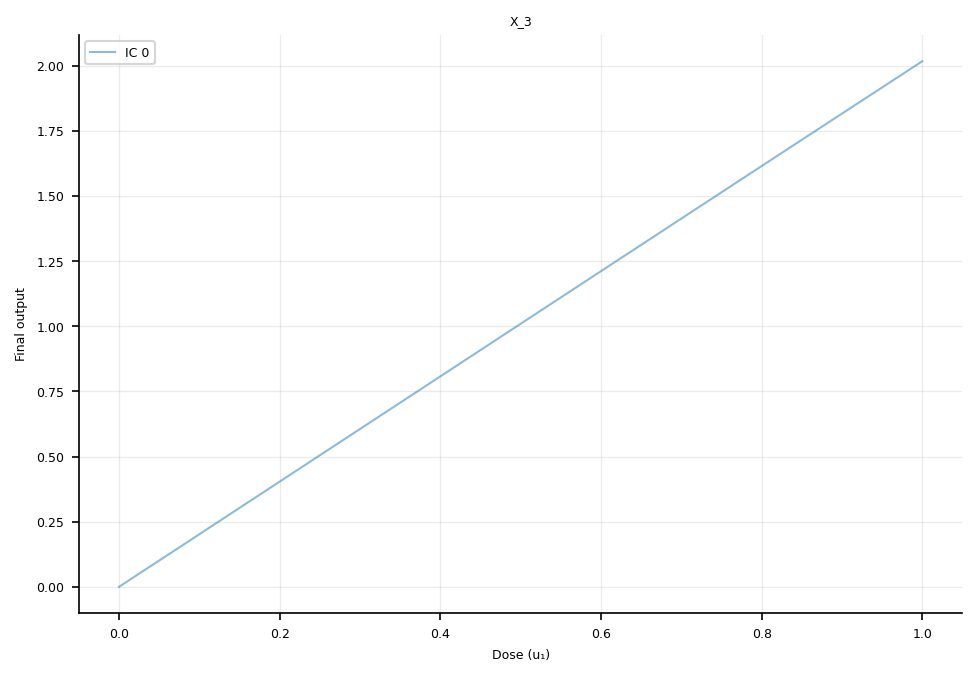

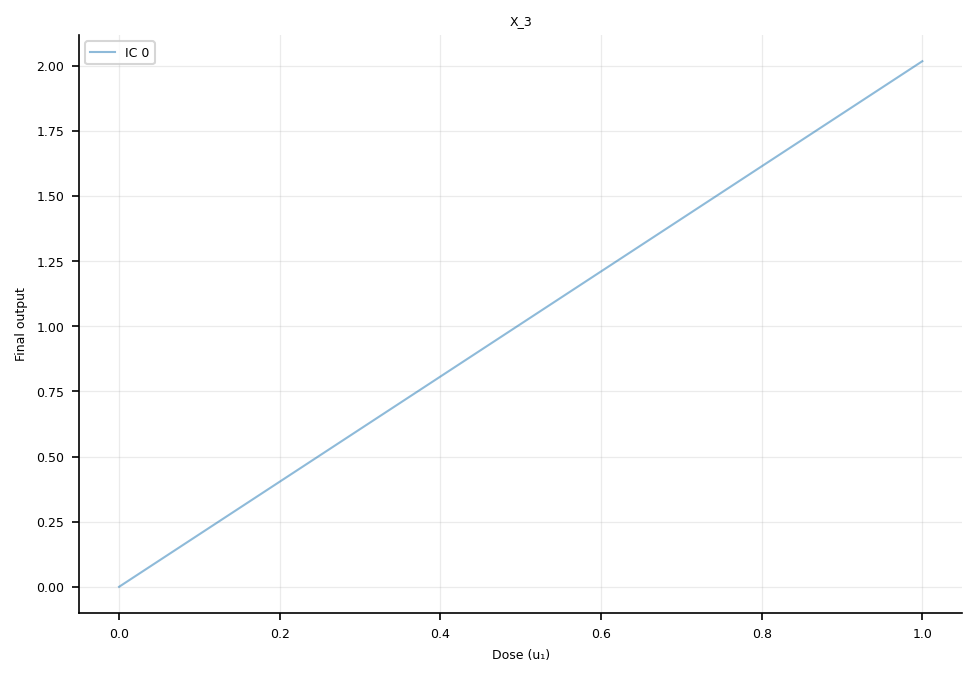

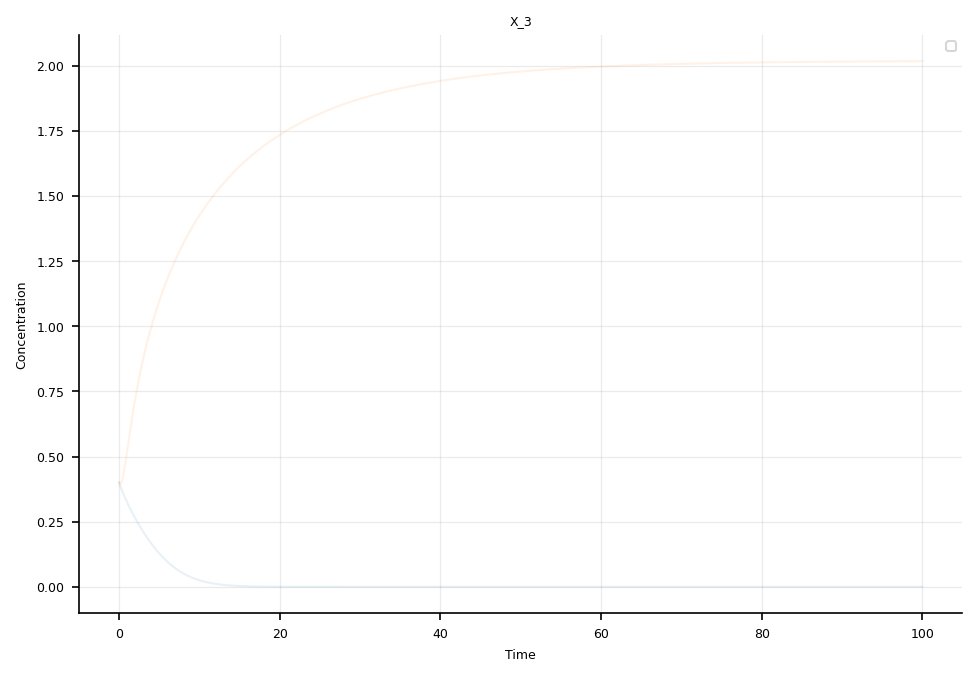

In [18]:
hof_crns = [item.state for item in trainer.s.mult_env.hall_of_fame]

trainer.s.crn_template

crns_new = trainer.resimulate(
    hof_crns,
    ic=("constant", 0.4), 
    u_spec=("grid", [0.0, 1.0]),
)

trainer.inspect(crns_new[0])
crns_new[0].plot_transient_response(); plt.show()
